# Analysis of Models using only MIMIC Notes

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pickle
import numpy as np
import pandas as pd

from pathlib import Path
from scipy import stats
from itertools import combinations
from tqdm import tqdm_notebook as tqdm

from utils.metrics import BinaryAvgMetrics
from utils.plots import *

In [2]:
from lr.full_common_args import args as lr_args
from rf.full_common_args import args as rf_args
from gbm.full_common_args import args as gbm_args

notes_vital_thresh = {
  'lr': lr_args.notes_common_vital_threshold,
  'rf': rf_args.notes_common_vital_threshold,
  'gbm': gbm_args.notes_common_vital_threshold
}

notes_all_thresh = {
  'lr': lr_args.notes_common_all_threshold,
  'rf': rf_args.notes_common_all_threshold,
  'gbm': gbm_args.notes_common_all_threshold
}

full_vital_thresh = {
  'lr': lr_args.full_common_vital_threshold,
  'rf': rf_args.full_common_vital_threshold,
  'gbm': gbm_args.full_common_vital_threshold
}

full_all_thresh = {
  'lr': lr_args.full_common_all_threshold,
  'rf': rf_args.full_common_all_threshold,
  'gbm': gbm_args.full_common_all_threshold
}

In [3]:
path = Path('data')
cohort = 'full_common'
workdir = path/f'workdir/{cohort}'
figdir = workdir/'figdir'

## Functions

In [4]:
def get_ensemble(ensembles, thresh, bams):  
  outputs = {}
  for ens_model in ensembles:
    key = '-'.join(ens_model)
    targs = bams[ens_model[0]].targs
    avg_thresh = np.array([thresh[model] for model in ens_model]).mean()
    max_thresh = max([thresh[model] for model in ens_model])
    probs = []
    for i in range(len(targs)):
      prob = []
      for model in ens_model:
        prob.append(bams[model].pos_probs[i])
      probs.append(np.stack(prob))

    avg_probs = [probs.mean(axis=0) for probs in probs]
    max_probs = [probs.max(axis=0) for probs in probs]

    avg_preds = [(probs > avg_thresh).astype(np.int64) for probs in avg_probs]
    max_preds = [(probs > max_thresh).astype(np.int64) for probs in max_probs]
    outputs[f'avg-{key}'] = (targs, avg_preds, avg_probs, avg_thresh)
    outputs[f'max-{key}'] = (targs, max_preds, max_probs, max_thresh)
    
  return outputs

In [13]:
def do_ttest(bams, model1, model2, metric):  
  if metric == 'sensitivity':
    x1 = bams[model1].sensitivities()
    x2 = bams[model2].sensitivities()
  elif metric == 'specificity':
    x1 = bams[model1].specificities()
    x2 = bams[model2].specificities()
  elif metric == 'ppv':
    x1 = bams[model1].ppvs()
    x2 = bams[model2].ppvs()
  elif metric == 'auroc':
    x1 = bams[model1].aurocs()
    x2 = bams[model2].aurocs()
  elif metric == 'npv':
    x1 = bams[model1].npvs()
    x2 = bams[model2].npvs()
  elif metric == 'f1':    
    x1 = bams[model1].f1s()
    x2 = bams[model2].f1s()

  t, p = stats.ttest_ind(x1, x2)
  return np.round(t, 2), max(np.round(p, 2), 0.001)

## Ensembles

In [16]:
prefix = 'full_common_vital'

if prefix == 'notes_common_vital':
  thresh = notes_vital_thresh
elif prefix == 'full_common_vital':
  thresh = full_vital_thresh

In [17]:
models = ['lr', 'rf', 'gbm']
bams = {}

for model in models:
  with open(workdir/model/f'{prefix}_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    probs = pickle.load(f)
    preds = pickle.load(f)
  bams[model] = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])

In [18]:
# ens_models = [
#   ['lr', 'rf'],
#   ['lr', 'gbm'],
#   ['rf', 'gbm'],  
#   ['lr', 'rf', 'gbm'],
# ]

ens_models = [m for m in sum([list(map(list, combinations(models, i))) for i in range(len(models) + 1)], []) if len(m) > 1]

In [19]:
ensembles = get_ensemble(ens_models, thresh, bams)

for model, vals in ensembles.items():
  bams[model] = BinaryAvgMetrics(*vals[:-1])  

### Checkpoint

In [20]:
final_metrics = {}

for key in bams.keys():
  final_metrics[key] = []
  for i in range(len(bams[key].get_avg_metrics())):
    final_metrics[key].append(bams[key].get_avg_metrics().iloc[i]['Value'])

In [21]:
final_metrics = pd.DataFrame(final_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1']).transpose()

best_models = pd.DataFrame([(final_metrics[metric].idxmax(), final_metrics[metric].max()) for metric in final_metrics], columns=['model', 'value'], index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])

In [22]:
final_metrics

,sensitivity,specificity,ppv,auroc,npv,f1
lr,0.824,0.574,0.359,0.768,0.918,0.500
rf,0.822,0.583,0.364,0.769,0.918,0.504
gbm,0.830,0.576,0.362,0.775,0.921,0.504
avg-lr-rf,0.834,0.573,0.362,0.777,0.922,0.504
max-lr-rf,0.831,0.569,0.359,0.770,0.920,0.501
avg-lr-gbm,0.840,0.572,0.363,0.780,0.925,0.506
max-lr-gbm,0.878,0.511,0.342,0.776,0.935,0.492
avg-rf-gbm,0.834,0.578,0.364,0.778,0.923,0.507
max-rf-gbm,0.834,0.573,0.361,0.775,0.922,0.504
avg-lr-rf-gbm,0.842,0.574,0.364,0.781,0.926,0.508


In [23]:
best_models

,model,value
sensitivity,max-lr-rf-gbm,0.879
specificity,rf,0.583
ppv,rf,0.364
auroc,avg-lr-rf-gbm,0.781
npv,max-lr-gbm,0.935
f1,avg-lr-rf-gbm,0.508


In [24]:
models = list(final_metrics.index)
metrics = list(final_metrics.columns)

In [25]:
ttests = {}

for m1, m2 in combinations(models, 2):  
  ttests[f'{m1}:{m2}'] = {}
  for metric in metrics:
    ttests[f'{m1}:{m2}'][metric] = do_ttest(bams, m1, m2, metric)

ttests = pd.DataFrame(ttests).transpose()

In [26]:
pickle.dump(bams, open(workdir/f'{prefix}_bams.pkl', 'wb'))
final_metrics.to_csv(workdir/f'{prefix}_metrics.csv', float_format='%.3f')
best_models.to_csv(workdir/f'{prefix}_best_models.csv', float_format='%.3f')
ttests.to_csv(workdir/f'{prefix}_ttests.csv')

## Results

In [4]:
prefixs = ['notes_common_vital', 'full_common_vital']
ptr = iter(prefixs)

In [5]:
best_all = {}

### Best Models

In [10]:
prefix = next(ptr)
best_all[prefix] = {}
print(prefix)

full_common_vital


In [11]:
bams = pickle.load(open(workdir/f'{prefix}_bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/f'{prefix}_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/f'{prefix}_best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/f'{prefix}_ttests.csv', index_col=0)

bams['avg-all'] = bams.pop('avg-lr-rf-gbm')
bams['max-all'] = bams.pop('max-lr-rf-gbm')

In [12]:
best_models.reset_index(inplace=True)
best_models

,index,model,value
0,sensitivity,max-lr-rf-gbm,0.879
1,specificity,rf,0.583
2,ppv,rf,0.364
3,auroc,avg-lr-rf-gbm,0.781
4,npv,max-lr-gbm,0.935
5,f1,avg-lr-rf-gbm,0.508


In [13]:
for i, row in best_models.iterrows():
  if i > 3: break
  best_all[prefix][row['index']] = (row['model'], row['value'])

### Best ttests

In [14]:
best_all

{'notes_common_vital': {'sensitivity': ('max-lr-rf-gbm', 0.826),
  'specificity': ('gbm', 0.616),
  'ppv': ('gbm', 0.37),
  'auroc': ('avg-lr-rf-gbm', 0.773)},
 'full_common_vital': {'sensitivity': ('max-lr-rf-gbm', 0.879),
  'specificity': ('rf', 0.583),
  'ppv': ('rf', 0.364),
  'auroc': ('avg-lr-rf-gbm', 0.7809999999999999)}}

In [15]:
nxbams = pickle.load(open(workdir/f'notes_common_vital_bams.pkl', 'rb'))
nvbams = pickle.load(open(workdir/f'full_common_vital_bams.pkl', 'rb'))
# nvlbams = pickle.load(open(workdir/f'full_common_all_bams.pkl', 'rb'))

In [21]:
mets = ['sensitivity', 'specificity', 'ppv', 'auroc']
itr = iter(mets)

In [25]:
met = next(itr)
print(met)

if met == 'sensitivity':
  nx = nxbams[best_all['notes_common_vital'][met][0]].sensitivities()
  nv = nvbams[best_all['full_common_vital'][met][0]].sensitivities()
elif met == 'specificity':
  nx = nxbams[best_all['notes_common_vital'][met][0]].specificities()
  nv = nvbams[best_all['full_common_vital'][met][0]].specificities()
if met == 'ppv':
  nx = nxbams[best_all['notes_common_vital'][met][0]].ppvs()
  nv = nvbams[best_all['full_common_vital'][met][0]].ppvs()
if met == 'auroc':
  nx = nxbams[best_all['notes_common_vital'][met][0]].aurocs()
  nv = nvbams[best_all['full_common_vital'][met][0]].aurocs()
  
# nvl = nvlbams[best_all['full_common_all'][met][0]].sensitivities()

_, p_nx_nv = stats.ttest_ind(nx, nv)
# _, p_nx_nvl = stats.ttest_ind(nx, nvl)
# _, p_nv_nvl = stats.ttest_ind(nv, nvl)
p_nx_nv = max(np.round(p_nx_nv, 2), 0.001)
# p_nx_nvl = max(np.round(p_nx_nvl, 2), 0.001)
# p_nv_nvl = max(np.round(p_nv_nvl, 2), 0.001)

# p_nx_nv, p_nx_nvl, p_nv_nvl
p_nx_nv

auroc


0.001

### Stats

In [ ]:
def get_stats(met):
  return {
    'min': met.min(),
    '25p': np.percentile(met, 25),
    'mean': met.mean(),
    'median': np.median(met),
    '75p': np.percentile(met, 75),
    'max': met.max(),
  }
  return mets.sensitivities().min()

In [ ]:
prefix = next(ptr)
print(prefix)

In [ ]:
bams = pickle.load(open(workdir/f'{prefix}_bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/f'{prefix}_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/f'{prefix}_best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/f'{prefix}_ttests.csv', index_col=0)

bams['avg-all'] = bams.pop('avg-lr-rf-gbm')
bams['max-all'] = bams.pop('max-lr-rf-gbm')

In [ ]:
itr = iter(bams.keys())
bams.keys()

In [ ]:
model = next(itr)
print(model)

In [ ]:
m = get_stats(bams[model].sensitivities())
print(f"m_min: {m['min']*100:0.1f}")
print(f"m_25: {m['25p']*100:0.1f}")
print(f"m_mean: {m['mean']*100:0.1f}")
print(f"m_median: {m['median']*100:0.1f}")
print(f"m_75: {m['75p']*100:0.1f}")
print(f"m_max: {m['max']*100:0.1f}")

In [ ]:
m = get_stats(bams[model].specificities())
print(f"m_min: {m['min']*100:0.1f}")
print(f"m_25: {m['25p']*100:0.1f}")
print(f"m_mean: {m['mean']*100:0.1f}")
print(f"m_median: {m['median']*100:0.1f}")
print(f"m_75: {m['75p']*100:0.1f}")
print(f"m_max: {m['max']*100:0.1f}")

In [ ]:
m = get_stats(bams[model].ppvs())
print(f"m_min: {m['min']*100:0.1f}")
print(f"m_25: {m['25p']*100:0.1f}")
print(f"m_mean: {m['mean']*100:0.1f}")
print(f"m_median: {m['median']*100:0.1f}")
print(f"m_75: {m['75p']*100:0.1f}")
print(f"m_max: {m['max']*100:0.1f}")

In [ ]:
m = get_stats(bams[model].aurocs())
print(f"m_min: {m['min']*100:0.1f}")
print(f"m_25: {m['25p']*100:0.1f}")
print(f"m_mean: {m['mean']*100:0.1f}")
print(f"m_median: {m['median']*100:0.1f}")
print(f"m_75: {m['75p']*100:0.1f}")
print(f"m_max: {m['max']*100:0.1f}")

## Box Plot

In [30]:
plot_dfs = []

In [32]:
prefix,cohort = 'full_common_vital','Notes & Vitals (U+S)'

bams = pickle.load(open(workdir/f'{prefix}_bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/f'{prefix}_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/f'{prefix}_best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/f'{prefix}_ttests.csv', index_col=0)

for k in bams.keys():
  bams[k.upper()] = bams.pop(k)

bams['AVG-ALL'] = bams.pop('AVG-LR-RF-GBM')
bams['MAX-ALL'] = bams.pop('MAX-LR-RF-GBM')

itr = iter(bams.keys())
bams.keys()

metrics = {}

for md in itr:
  df = pd.DataFrame()
  for k, m in bams[md].yield_metrics():
    df[k] = m
  df['Model'] = md
  cols = list(df.columns)
  cols = [cols[-1]] + cols[:-1]
  df = df[cols]
  metrics[md] = df

plot_df = pd.concat(metrics.values())
plot_df['Cohort'] = cohort
plot_dfs.append(plot_df)

In [33]:
plot_df = pd.concat(plot_dfs)
plot_df[['Sensitivity', 'Specificity', 'PPV', 'AUC']] = plot_df[['Sensitivity', 'Specificity', 'PPV', 'AUC']] * 100
plot_df.shape

(2200, 8)

Text(0.5, 0, '')

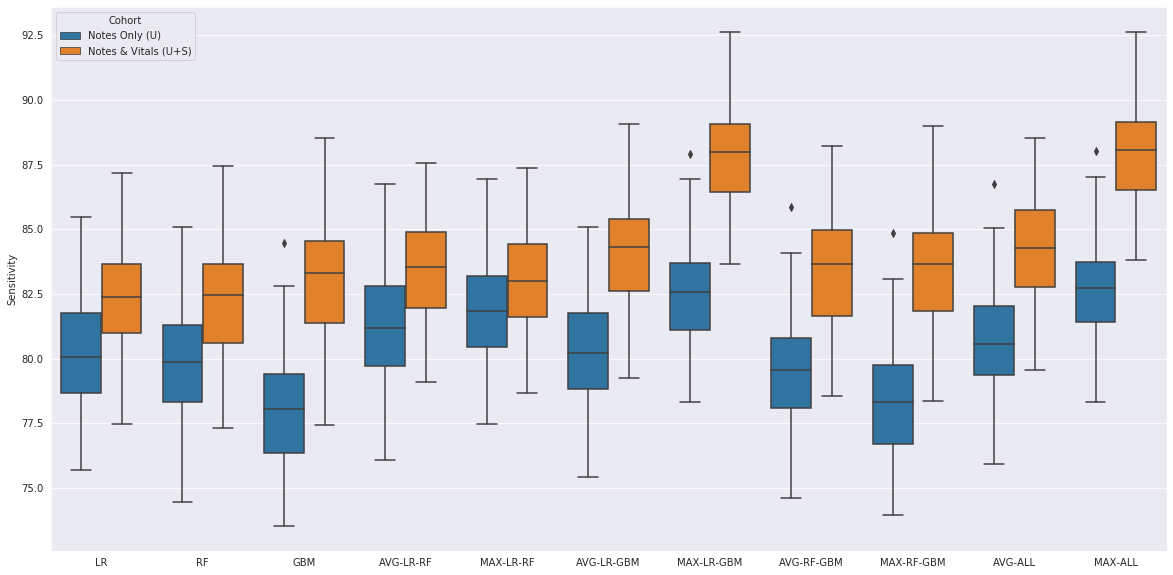

In [35]:
met = 'Sensitivity'

fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(x='Model', y=met, hue='Cohort', data=plot_df, ax=ax)
# for i in range(10): plt.axvline(x=i+0.5, ls='-.', color='black')
ax.set_xlabel('')

In [28]:
save = True
if save:
  fig.savefig(figdir/f'nxv_{met.lower()}_box_plot.pdf', dpi=300)

## Mean AUC

In [ ]:
def get_mean_tprs(bams, base_fpr):
  mean_tprs = {}  
  for model, bam in bams.items():
    tprs = []  
    for i, (targs, probs) in enumerate(zip(bam.targs, bam.pos_probs)):
      fpr, tpr, _ = roc_curve(targs, probs)
      tpr = interp(base_fpr, fpr, tpr)
      tpr[0] = 0.0
      tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs[model] = tprs.mean(axis=0)
    
  return mean_tprs

In [ ]:
save = True

In [ ]:
prefix = 'full_common_all'

bams = pickle.load(open(workdir/f'{prefix}_bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/f'{prefix}_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/f'{prefix}_best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/f'{prefix}_ttests.csv', index_col=0)

for k in bams.keys():
  bams[k.upper()] = bams.pop(k)

bams['AVG-ALL'] = bams.pop('AVG-LR-RF-GBM')
bams['MAX-ALL'] = bams.pop('MAX-LR-RF-GBM')

In [ ]:
des = 'all_'

if not des:
  plot_bams = {k: bams[k] for k in bams.keys() if '-' not in k}
  des = ''  
  names = plot_bams.keys()
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]
elif des == 'avg_':
  plot_bams = {k: bams[k] for k in bams.keys() if 'avg' in k}
  names = [name[4:] for name in plot_bams.keys()]
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]  
elif des == 'max_':
  plot_bams = {k: bams[k] for k in bams.keys() if 'max' in k}
  names = [name[4:] for name in plot_bams.keys()]
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]  
elif des == 'all_':
  plot_bams = bams
  names = plot_bams.keys()
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]
  
legends  

In [ ]:
base_fpr = np.linspace(0, 1, 100)
mean_tprs = get_mean_tprs(plot_bams, base_fpr)

fig, ax = plt.subplots(1, 1, figsize=(11, 8))
for i, (model, mean_tpr) in enumerate(mean_tprs.items()):
  ax.plot(base_fpr, mean_tpr)
ax.plot([0, 1], [0, 1], linestyle=':')  
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(legends)

if save:
  fig.savefig(figdir/f'{prefix}_{des}mean_auc.pdf', dpi=300)